In [1]:
import ast
import re
import pandas as pd
import math

In [2]:
def read_data(path):
    with open(path, 'r') as f:
        lines = f.readlines() 
        
    json_formatted = '['
    for line in lines:
        json_formatted += line + ','
    json_formatted = json_formatted[:-1] + ']' 
    json_formatted = re.sub('null', 'None', json_formatted)
    return ast.literal_eval(json_formatted)

In [3]:
drive = '/content/drive/MyDrive/IUM-project/'

df_deliveries = pd.DataFrame(read_data(drive + 'deliveries.jsonl'))
df_products = pd.DataFrame(read_data(drive + 'products.jsonl'))
df_sessions = pd.DataFrame(read_data(drive + 'sessions.jsonl'))
df_users = pd.DataFrame(read_data(drive + 'users.jsonl'))

In [4]:
df_sessions['timestamp'] = pd.to_datetime(df_sessions['timestamp'])

In [5]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2020-03-26 22:22:04,102.0,1276.0,VIEW_PRODUCT,0,NaN
1,100001,2020-03-26 22:26:16,102.0,1276.0,BUY_PRODUCT,0,20001.0
2,100002,2020-01-02 01:45:52,102.0,1234.0,VIEW_PRODUCT,5,NaN
3,100002,2020-01-02 01:48:45,102.0,1233.0,VIEW_PRODUCT,5,NaN
4,100002,2020-01-02 01:52:29,102.0,1233.0,BUY_PRODUCT,5,20002.0


In [6]:
df_products.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


In [7]:
import matplotlib.pyplot as plt

def plot_timeseries(df, column, n=10, df_labels=None, labels_column=None):
  cnt = df[column].value_counts()
  print(f'Unique values in "{column}": {len(cnt)}')
  idx = cnt.head(n).index
  plt.figure(figsize=(20, n))
  for i in range(n):
      plt.subplot(math.ceil(n / 5), 5, i+1)
      if df_labels is not None:
        plt.title(df_labels.loc[df_labels[column] == idx[i], labels_column].squeeze())
      else:
        plt.title(idx[i])
      temp = df[df[column] == idx[i]]
      temp.groupby([temp['timestamp'].dt.isocalendar().week])[column].count().plot()
  plt.show()




Unique values in "product_id": 217


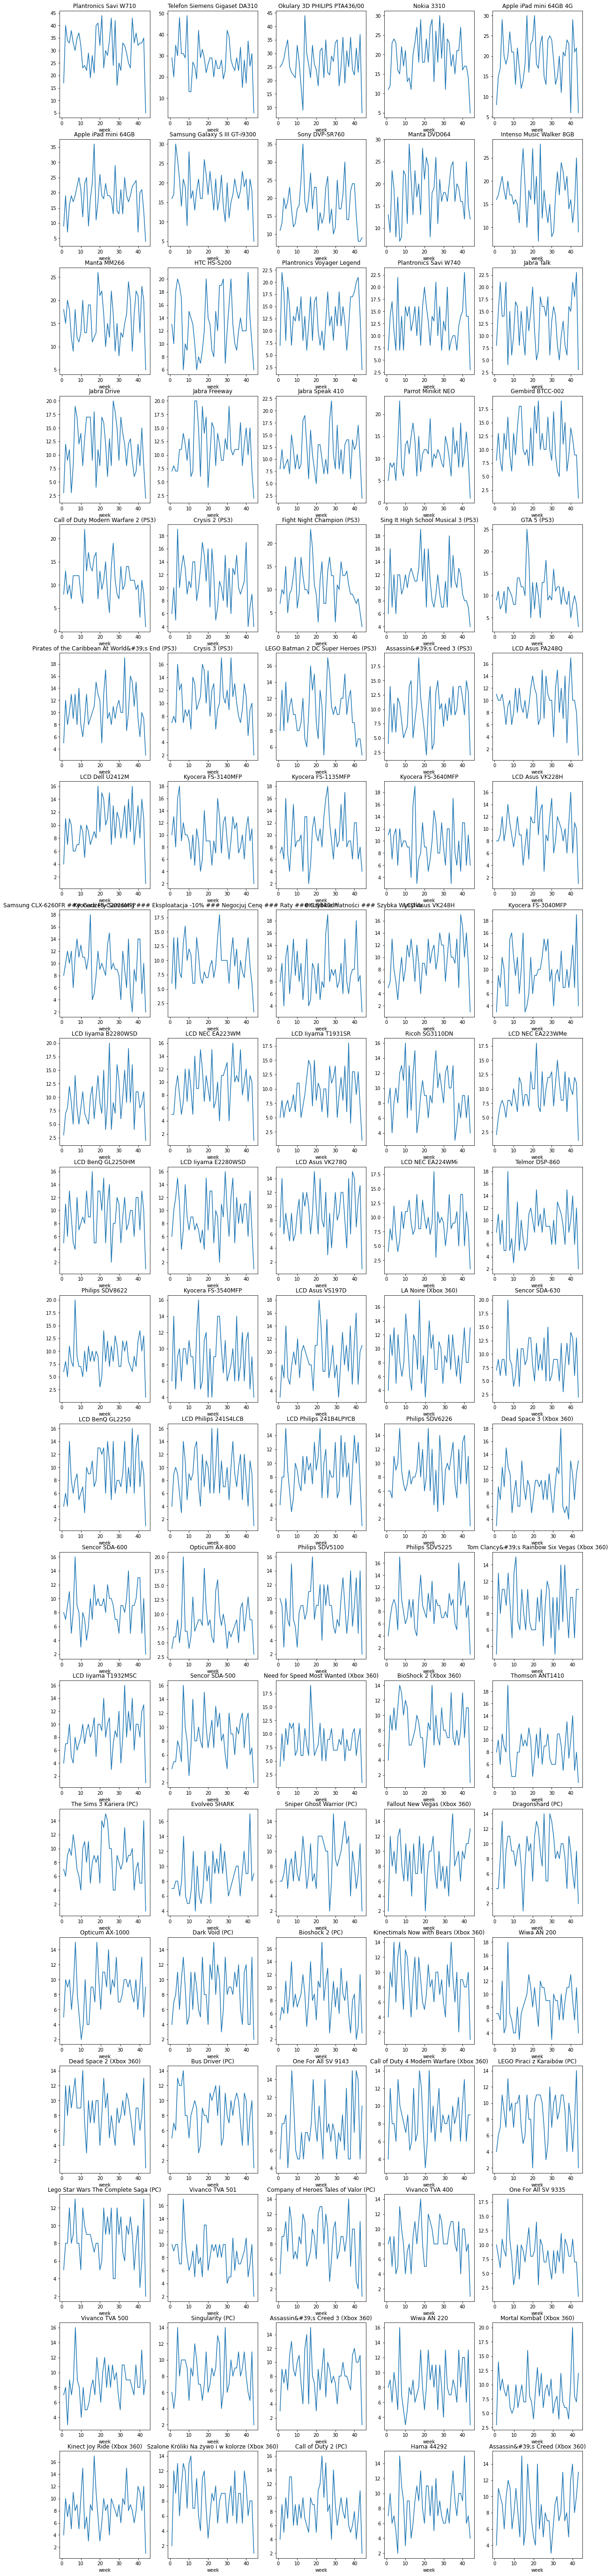

In [8]:
plot_timeseries(df_sessions, 'product_id', df_labels=df_products, labels_column='product_name', n=100)

In [9]:
df = df_products.set_index('product_id')
df_sessions = df_sessions.dropna(subset=['product_id'])
df_sessions.loc['product_id'] = df_sessions['product_id'].astype(int)
df = df_sessions.join(df, on='product_id')

Unique values in "category_path": 15


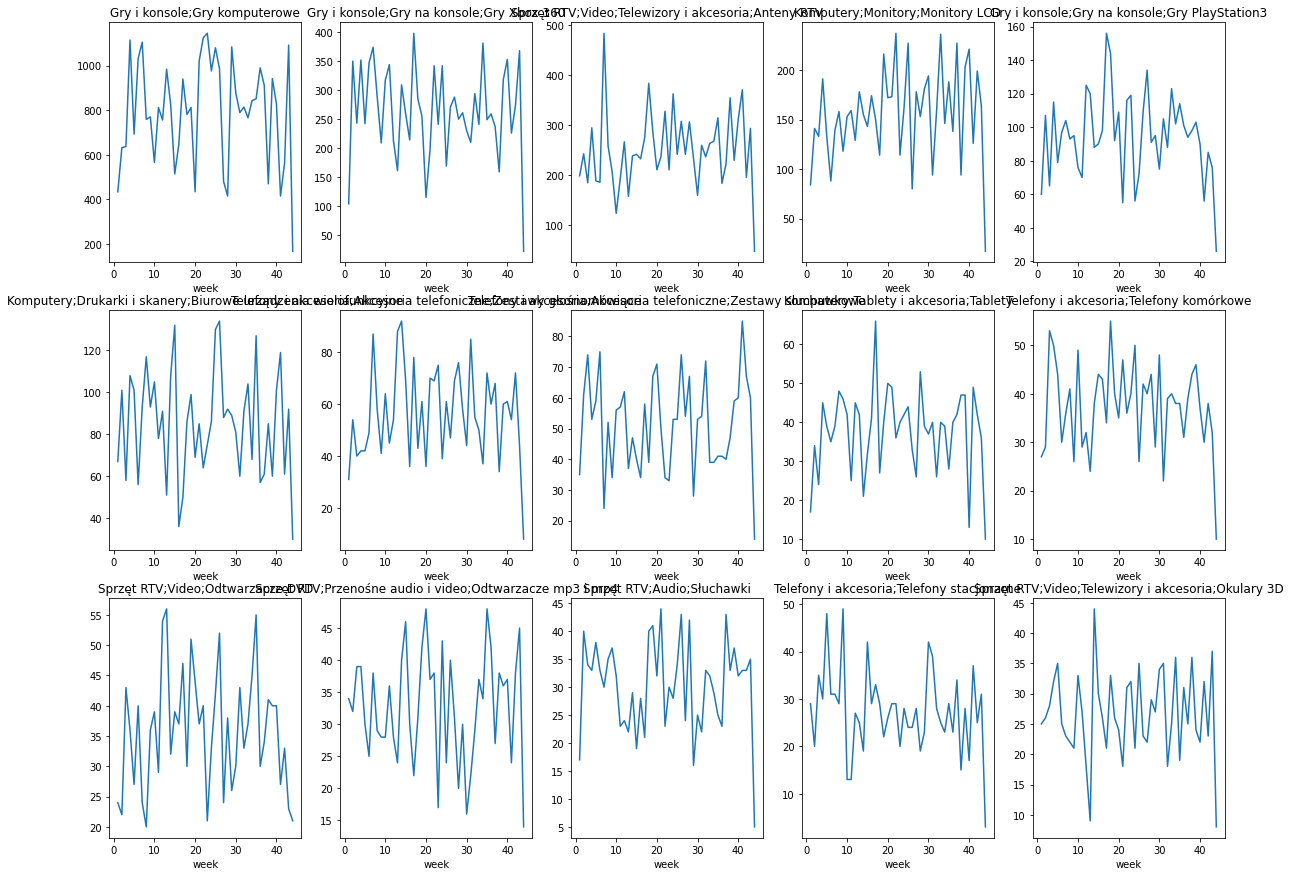

In [10]:
plot_timeseries(df, 'category_path', n=15)

In [11]:
len(df_products['category_path'].str.replace(';.*', '').unique())

4

Unique values in "category_path": 4


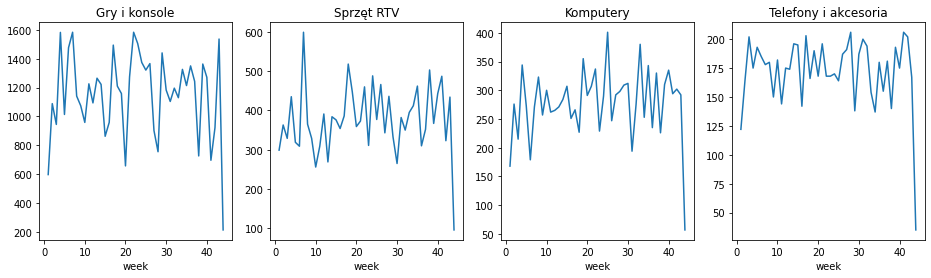

In [15]:
df_new = df.copy()
df_new['category_path'] = df_new['category_path'].str.replace(';.*', '')
plot_timeseries(df_new, 'category_path', n=4)